In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg  

In [2]:
population = pd.read_csv('../data/curated/suburb_population2001-2021.csv')
income = pd.read_csv('../data/curated/suburb_income.csv')
rental = pd.read_csv('../data/curated/select_rent.csv',index_col = 0) 

In [3]:
target_suburb = list(set(population.Suburb) & set(income.Suburb) & set(rental.Suburb))

In [100]:
select_population = population[population['Suburb'].isin(target_suburb)].drop_duplicates(['Suburb'])
cols = range(18)
time_population = select_population.set_index('Suburb').iloc[:,cols]

In [5]:
select_income = income[income['Suburb'].isin(target_suburb)].drop_duplicates(['Suburb'])
time_income = select_income.set_index('Suburb').drop('SA2_code', axis=1)

In [6]:
select_rental = rental[rental['Suburb'].isin(target_suburb)].drop_duplicates(['Suburb'])
cols = [0] + list(range(2,152,2))
time_rental = select_rental.iloc[:, cols].set_index('Suburb')

In [7]:
time_rental = time_rental.replace('-', np.nan).astype(float)
time_rental = time_rental.apply(lambda x: x.fillna(x.mean()),axis=0)

### Predict Growth Rate for Rental Price

In [301]:
# train autoregression
all_predictions = list()
for X in time_rental.values:
    model = AutoReg(X, lags=15)
    model_fit = model.fit()
    all_predictions.append(model_fit.predict(start=len(X), end=len(X)+27, dynamic=True))

In [302]:
pred = pd.DataFrame(all_predictions)
COLS = ['(Pred) Mar 2019 Median', '(Pred) Jun 2019 Median', '(Pred) Sep 2019 Median', '(Pred) Dec 2019 Median',
        '(Pred) Mar 2020 Median', '(Pred) Jun 2020 Median', '(Pred) Sep 2020 Median', '(Pred) Dec 2020 Median',
        '(Pred) Mar 2021 Median', '(Pred) Jun 2021 Median', '(Pred) Sep 2021 Median', '(Pred) Dec 2021 Median',
        '(Pred) Mar 2022 Median', '(Pred) Jun 2022 Median', '(Pred) Sep 2022 Median', '(Pred) Dec 2022 Median',
        '(Pred) Mar 2023 Median', '(Pred) Jun 2023 Median', '(Pred) Sep 2023 Median', '(Pred) Dec 2023 Median',
        '(Pred) Mar 2024 Median', '(Pred) Jun 2024 Median', '(Pred) Sep 2024 Median', '(Pred) Dec 2024 Median',
        '(Pred) Mar 2025 Median', '(Pred) Jun 2025 Median', '(Pred) Sep 2025 Median', '(Pred) Dec 2025 Median']
pred.columns = COLS

In [303]:
predict_rent = pd.concat([time_rental, pred.set_index(time_rental.index)], axis=1)

In [316]:
predict_rent

,Mar 2000 Median,Jun 2000 Median,Sep 2000 Median,Dec 2000 Median,Mar 2001 Median,Jun 2001 Median,Sep 2001 Median,Dec 2001 Median,Mar 2002 Median,Jun 2002 Median,...,(Pred) Sep 2023 Median,(Pred) Dec 2023 Median,(Pred) Mar 2024 Median,(Pred) Jun 2024 Median,(Pred) Sep 2024 Median,(Pred) Dec 2024 Median,(Pred) Mar 2025 Median,(Pred) Jun 2025 Median,(Pred) Sep 2025 Median,(Pred) Dec 2025 Median
Suburb,,,,,,,,,,,,,,,,,,,,,
ALBERT PARK,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,300.0,300.0,...,643.626254,647.603635,650.042853,656.509708,662.800839,661.650565,672.817565,673.041088,673.493139,687.594773
MIDDLE PARK,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,300.0,300.0,...,643.626254,647.603635,650.042853,656.509708,662.800839,661.650565,672.817565,673.041088,673.493139,687.594773
ARMADALE,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,235.0,230.0,...,501.561812,509.803255,516.825470,516.507500,518.849551,514.984469,513.440193,512.250900,510.452026,514.707454
CARLTON NORTH,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,290.0,290.0,...,632.758954,635.610051,638.802302,641.394335,643.401149,646.117095,648.729927,650.632226,652.856948,655.583191
CARLTON,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,270.0,270.0,...,520.898853,527.444899,534.781584,542.340563,549.752002,557.415421,565.267282,573.043951,580.620509,588.796247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SWAN HILL,130.0,135.0,135.0,140.0,140.0,140.0,135.0,140.0,140.0,140.0,...,271.894423,273.193958,273.779256,275.050336,275.943950,276.509092,277.806059,278.540991,279.405729,280.521340
TORQUAY,155.0,160.0,165.0,170.0,170.0,175.0,180.0,180.0,190.0,190.0,...,570.522503,574.418811,578.486560,581.786794,586.450906,590.633302,594.888989,599.658222,604.074586,608.126140
TRARALGON,125.0,120.0,125.0,125.0,125.0,125.0,130.0,125.0,130.0,130.0,...,295.673966,295.924004,296.698838,297.150071,297.880023,298.575065,299.040247,299.688751,300.087543,300.876632


In [305]:
growth_rate_rent_3_years = (predict_rent['(Pred) Dec 2021 Median'] - 
                                       predict_rent['Dec 2018 Median']) / predict_rent['Dec 2018 Median']
growth_rate_rent_5_years = (predict_rent['(Pred) Dec 2023 Median'] - 
                                       predict_rent['Dec 2018 Median']) / predict_rent['Dec 2018 Median']
growth_rate_rent_7_years = (predict_rent['(Pred) Dec 2025 Median'] - 
                                       predict_rent['Dec 2018 Median']) / predict_rent['Dec 2018 Median']

In [306]:
growth_rate_rent = pd.DataFrame([growth_rate_rent_3_years, growth_rate_rent_5_years, growth_rate_rent_7_years]).transpose()
growth_rate_rent.columns = ['% Growth in 3 years','% Growth in 5 years', '% Growth in 7 years']

In [337]:
growth_rate_rent_sorted = growth_rate_rent.sort_values('% Growth in 7 years', ascending=False)
growth_rate_rent_sorted['rental rank'] = range(1,len(growth_rate_rent_sorted)+1)

In [338]:
growth_rate_rent_sorted

,% Growth in 3 years,% Growth in 5 years,% Growth in 7 years,rental rank
Suburb,,,,
SEYMOUR,0.149492,0.266960,0.394370,1
CARLTON,0.121448,0.232348,0.375692,2
PARKVILLE,0.121448,0.232348,0.375692,3
CORIO,0.235292,0.291872,0.320597,4
MORNINGTON,0.121925,0.194710,0.277924,5
...,...,...,...,...
DOCKLANDS,-0.000567,0.009660,0.016505,179
CRANBOURNE,0.021286,0.020634,0.013677,180
WINDSOR,0.010819,-0.001446,0.006721,181


### Predict Growth Rate for Income

In [291]:
# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

# train autoregression
all_predictions = list()
for X in time_income.values:
    model = AutoReg(X, lags=2)
    model_fit = model.fit()
    all_predictions.append(model_fit.predict(start=len(X), end=len(X)+6, dynamic=True))

In [292]:
pred = pd.DataFrame(all_predictions)
COLS = list(range(2019, 2026))
pred.columns = [str(x) for x in COLS]

In [293]:
predict_income = pd.concat([time_income, pred.set_index(time_income.index)], axis=1)

In [318]:
predict_income

,2005_income,2006_income,2007_income,2008_income,2009_income,2010_income,2011_income,2012_income,2013_income,2014_income,...,2016_income,2017_income,2018_income,2019,2020,2021,2022,2023,2024,2025
Suburb,,,,,,,,,,,,,,,,,,,,,
EAST MELBOURNE,80524.0,87975.0,79947.0,90831.0,95349.0,105396.0,107768.0,104960.0,116888.0,114762.0,...,124057.0,128069.0,132130.0,135650.125102,139489.665351,143117.743837,146862.015088,150520.307637,154217.421703,157876.373234
SOUTHBANK,61242.0,67480.0,65682.0,70876.0,71064.0,82798.0,88106.0,87449.0,87266.0,89607.0,...,91651.0,94718.0,94237.0,95704.846787,96528.952881,97395.743033,98140.064192,98816.219935,99420.433905,99962.925106
DOCKLANDS,56900.0,62884.0,64625.0,64491.0,64633.0,69732.0,73182.0,71884.0,72349.0,72972.0,...,68978.0,69260.0,71476.0,71486.573168,71441.330650,71408.700657,71386.427016,71371.264380,71360.943968,71353.919455
FOOTSCRAY,36482.0,37360.0,38467.0,41170.0,42943.0,42600.0,45491.0,46902.0,48180.0,49954.0,...,52664.0,55519.0,57701.0,59707.894456,61860.269797,64058.184063,66336.753614,68687.850530,71117.329013,73626.662991
SEDDON,36635.0,38005.0,39443.0,42187.0,43745.0,57518.0,59896.0,61714.0,63637.0,65726.0,...,71878.0,75083.0,78218.0,80600.246241,82951.281897,85195.949921,87347.192763,89407.994711,91382.258184,93273.606057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MORNINGTON,37877.0,41007.0,40777.0,44590.0,43980.0,47445.0,49575.0,50799.0,53760.0,55845.0,...,58594.0,60236.0,62275.0,63959.156707,65915.010509,67674.604366,69587.475119,71392.563207,73284.871206,75118.763196
DROMANA,33249.0,34807.0,35095.0,37260.0,39295.0,42105.0,46850.0,47982.0,49683.0,51660.0,...,55235.0,57195.0,59787.0,61951.851839,64106.230028,66268.854956,68440.602972,70621.550457,72811.738078,75011.205061
PORTSEA,39071.0,41569.0,37181.0,41806.0,42168.0,45563.0,47878.0,49674.0,51972.0,52866.0,...,59717.0,60284.0,61551.0,64247.441038,66348.219100,68893.433796,71357.315174,74014.361864,76730.431982,79580.414077


In [295]:
growth_rate_inc_3_years = (predict_income['2021'] - 
                                       predict_income['2018_income']) / predict_income['2018_income']
growth_rate_inc_5_years = (predict_income['2023'] - 
                                       predict_income['2018_income']) / predict_income['2018_income']
growth_rate_inc_7_years = (predict_income['2025'] - 
                                       predict_income['2018_income']) / predict_income['2018_income']

In [296]:
growth_rate_inc = pd.DataFrame([growth_rate_inc_3_years, growth_rate_inc_5_years, growth_rate_inc_7_years]).transpose()
growth_rate_inc.columns = ['% Growth in 3 years','% Growth in 5 years', '% Growth in 7 years']

In [339]:
growth_rate_inc_sorted = growth_rate_inc.sort_values('% Growth in 7 years', ascending=False)
growth_rate_inc_sorted['income rank'] = range(1,len(growth_rate_inc_sorted)+1)

In [340]:
growth_rate_inc_sorted

,% Growth in 3 years,% Growth in 5 years,% Growth in 7 years,income rank
Suburb,,,,
PORT MELBOURNE,0.483210,0.429037,0.427720,1
FITZROY NORTH,0.144874,0.259192,0.388430,2
PRAHRAN,0.134770,0.244500,0.370567,3
WINDSOR,0.134770,0.244500,0.370567,4
HEIDELBERG,0.132183,0.240111,0.364494,5
...,...,...,...,...
BOX HILL,0.020176,0.024654,0.027547,179
PARKVILLE,0.005296,0.016506,0.025412,180
SOUTH YARRA,0.002651,0.007943,0.011738,181


### Predict Growth Rate for Population

In [280]:
# train autoregression
all_predictions = list()
for X in time_population.values:
    model = AutoReg(X, lags=1)
    model_fit = model.fit()
    all_predictions.append(model_fit.predict(start=len(X), end=len(X)+6, dynamic=True))
pred = pd.DataFrame(all_predictions)
COLS = list(range(2019, 2026))
pred.columns = [str(x) for x in COLS]

In [281]:
predict_population = pd.concat([time_population, pred.set_index(time_population.index)], axis=1)

In [282]:
predict_population

,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2016_population,2017_population,2018_population,2019,2020,2021,2022,2023,2024,2025
Suburb,,,,,,,,,,,,,,,,,,,,,
EAST MELBOURNE,3731,3859,4243,4460,4495,4555,4806,5055,5202,5272,...,5475,5495,5409,5435.060964,5457.409350,5476.574042,5493.008580,5507.101897,5519.187515,5529.551447
SOUTHBANK,5883,6050,6222,6467,6575,6704,6872,6985,7134,7174,...,8617,8760,8937,9142.286304,9350.649764,9562.136507,9776.793347,9994.667805,10215.808111,10440.263218
DOCKLANDS,154,926,1913,3089,3779,4152,4592,5040,5402,5780,...,11832,13923,15439,17141.197125,18987.484334,20990.058776,23162.150082,25518.107766,28073.496018,30845.196531
FOOTSCRAY,11564,11562,11615,11619,11731,11828,12085,12462,12815,13214,...,17343,17665,17891,18533.227386,19216.374367,19943.048141,20716.022021,21538.246025,22412.858130,23343.196251
SEDDON,4144,4143,4163,4181,4206,4256,4285,4341,4394,4419,...,4980,5011,5028,5109.492104,5195.237966,5285.459626,5380.390714,5480.277054,5585.377302,5695.963617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MORNINGTON,19118,19952,20347,20762,21151,21497,21966,22460,22854,23164,...,25030,25492,25897,26186.148435,26465.818423,26736.320670,26997.955703,27251.014192,27495.777281,27732.516899
DROMANA,3382,3422,3429,3433,3435,3454,3532,3621,3692,3699,...,4581,4803,4983,5274.812487,5615.010465,6011.616740,6473.984385,7013.017307,7641.427390,8374.034282
PORTSEA,1318,1347,1365,1369,1372,1378,1381,1385,1387,1388,...,1499,1530,1561,1592.013346,1626.359330,1664.396071,1706.520171,1753.170850,1804.834527,1862.049887


In [288]:
growth_rate_pop_3_years = (predict_population['2021'] - 
                                       predict_population['2018_population']) / predict_population['2018_population']
growth_rate_pop_5_years = (predict_population['2023'] - 
                                       predict_population['2018_population']) / predict_population['2018_population']
growth_rate_pop_7_years = (predict_population['2025'] - 
                                       predict_population['2018_population']) / predict_population['2018_population']

In [285]:
growth_rate_pop = pd.DataFrame([growth_rate_pop_3_years, growth_rate_pop_5_years, growth_rate_pop_7_years]).transpose()
growth_rate_pop.columns = ['% Growth in 3 years','% Growth in 5 years', '% Growth in 7 years']

In [341]:
growth_rate_pop_sorted = growth_rate_pop.sort_values('% Growth in 7 years', ascending=False)
growth_rate_pop_sorted['population rank'] = range(1,len(growth_rate_pop_sorted)+1)

In [342]:
growth_rate_pop_sorted

,% Growth in 3 years,% Growth in 5 years,% Growth in 7 years,population rank
Suburb,,,,
PORT MELBOURNE,27.376963,265.694897,2506.635369,1
WERRIBEE,0.327301,0.743022,1.447310,2
DOCKLANDS,0.359548,0.652834,0.997875,3
ALFREDTON,0.258478,0.482736,0.760129,4
GROVEDALE,0.244368,0.467111,0.753949,5
...,...,...,...,...
GREENSBOROUGH,-0.004388,-0.006671,-0.008547,179
WANTIRNA,-0.008792,-0.012098,-0.014206,180
KEILOR,-0.009990,-0.013923,-0.016522,181


In [345]:
ranking = pd.DataFrame([growth_rate_rent_sorted['rental rank'],
                        growth_rate_inc_sorted['income rank'], 
                        growth_rate_pop_sorted['population rank']]).transpose()

In [347]:
ranking['average rank'] = ranking.mean(axis=1)

In [356]:
ranking = ranking.sort_values('average rank')

In [357]:
ranking.to_csv('../data/curated/suburb_ranking.csv')

<AxesSubplot: >

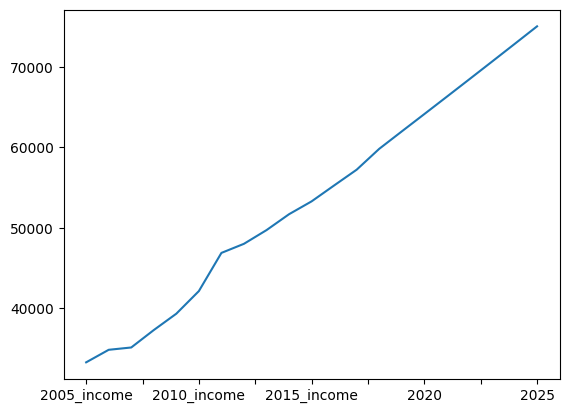

In [353]:
predict_income.loc['DROMANA'].plot()

<AxesSubplot: >

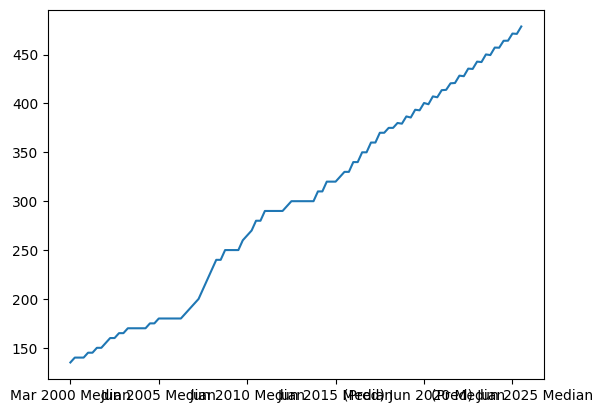

In [354]:
predict_rent.loc['DROMANA'].plot()

<AxesSubplot: >

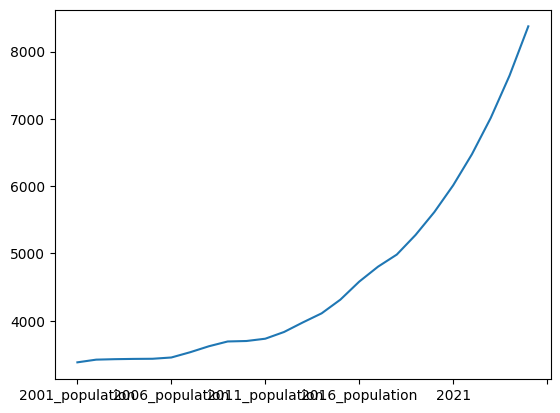

In [355]:
predict_population.loc['DROMANA'].plot()